In [1]:
import finesse
from finesse.gaussian import BeamParam
from finesse.knm import Map
from finesse.gaussian import optimise_HG00_q_scipy, optimise_HG00_q
from finesse.cymath.zernike import Znm_eval as Znm
from finesse.knm.matrix import KnmMatrix
from finesse.knm.maps import map_scattering_coefficients, scattering_coefficients_to_KnmMatrix

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from scipy.optimize import fsolve, minimize
from finesse.gaussian import HGMode
import scipy
import scipy.integrate as integrate
from sympy import symbols, I, conjugate, simplify, lambdify, Matrix
from sympy.functions.elementary.complexes import sign
import sympy as sp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np

finesse.configure(plotting=True)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

#### Spherical aberration for spherical mirrors vs. paraboloidal mirrors
$$
\Delta z = \underbrace{R - R\sqrt{1 - \frac{x^2+y^2}{R^2}}}_\text{Sphere} - \underbrace{\frac{x^2+y^2}{2R}}_\text{Paraboloid} 
\approx \underbrace{\frac{(x^2+y^2)^2}{8 R^3}}_\text{Leading Contribution}
$$
#### Beam phase front distortion
$$
\delta \phi = k \cdot 2\Delta z
$$
#### HOM scattering into 4th order modes and 2nd order modes

$$
\mathrm{HG}_{0,0} \cdot e^{i\delta \phi} \Rightarrow \mathrm{HG}_{0,0} + i\frac{k w^4}{32 R^3} \left(\underbrace{\sqrt{6}\times \mathrm{HG}_{4,0} \cdot e^{-4i\Psi}+ \sqrt{6}\times \mathrm{HG}_{0,4}\cdot e^{-4i\Psi} + 2\times \mathrm{HG}_{2,2}\cdot e^{-4i\Psi}}_\text{4th-order modes} + \underbrace{4\sqrt{2}\times \mathrm{HG}_{2,0}\cdot e^{-2i\Psi} + 4\sqrt{2}\times \mathrm{HG}_{0,2}\cdot e^{-2i\Psi}}_\text{2nd-order modes} + 4\times \mathrm{HG}_{0,0} \right)
$$

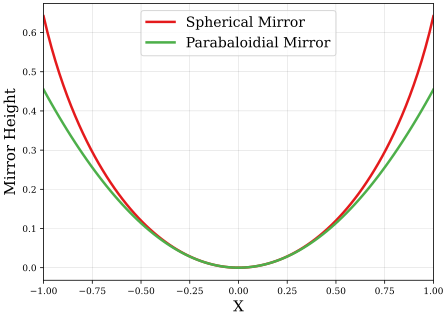

In [2]:
x = np.linspace(-1, 1, 100)
R = 1.1

sphere = R - R*(1 - x**2/R**2)**0.5
parabaloid = x**2/(2*R)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))

ax.plot(x, sphere, lw=2.5, color=CB_color_cycle[7], label="Spherical Mirror")
ax.plot(x, parabaloid, lw=2.5, color=CB_color_cycle[2], label="Parabaloidial Mirror")

ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Mirror Height', fontsize=15)
legend = ax.legend(fontsize=14, ncols=1, loc="best");

In [3]:
w = 5.4e-2 # beam size on aLIGO PR3 is about 5.4 cm
R = 36 # PR3 ROC

lambd = 1064e-9
k = 2*np.pi/lambd
coeff = k*w**4/(32*R**3)
fourthHOMPower = k**2*w**8/(64*R**6)
coeff, fourthHOMPower

(3.363224043213932e-05, 1.8098041543763624e-08)

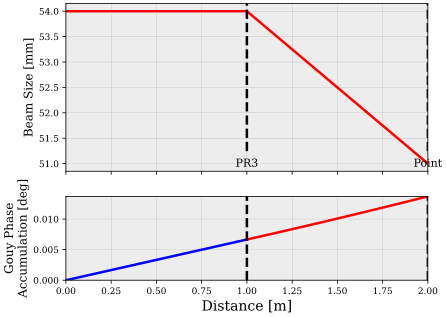

In [4]:
kat = finesse.Model()
kat.modes(maxtem=6)

w = 5.4e-2
Rc = np.inf
kat.parse(
    f"""
    gauss input PR3.p1.i priority=1 w={w} Rc={Rc}

    l L0 P=1

    s s0 L0.p1 PR3.p1 L=1

    bs PR3 R=1 T=0 Rc=36 alpha=0

    s s1 PR3.p2 Point.p1 L=1
    
    nothing Point

    ad HG00 Point.p2.o f=0 n=0 m=0
    
    ad HG20 Point.p2.o f=0 n=2 m=0
    ad HG02 Point.p2.o f=0 n=0 m=2

    ad HG40 Point.p2.o f=0 n=4 m=0
    ad HG04 Point.p2.o f=0 n=0 m=4
    ad HG22 Point.p2.o f=0 n=2 m=2

    noxaxis()

    """
)

tsy = finesse.tracing.tools.propagate_beam(
    from_node=kat.L0.p1.o, to_node=kat.Point.p2.o, direction="x"
)

fig, (ax1, ax2)  = tsy.plot()
background_color = '#ededed'

ax1.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)

# ax2.set_ylim([-5, 95])
# ax2.set_yticks([0, 30, 60, 90])

ax2.set_xlabel('Distance [m]', fontsize=14)
ax1.set_ylabel('Beam Size [mm]', fontsize=12)
ax2.set_ylabel('Gouy Phase\nAccumulation [deg]', fontsize=12)

for line in ax1.get_lines()+ax2.get_lines():
    line.set_linewidth(2.5)

fig.set_size_inches(6.5, 5);

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
ax1.set_subplotspec(gs[0])
ax2.set_subplotspec(gs[1])

# text_objects = ax1.texts
# for text_object in text_objects:
#     text_object.set_text(text_object.get_text().capitalize())

In [5]:
print(tsy.table())

┌────────────╥─────┬───────────┬───────────┬───────┬───────────┬────────────┬───────────┬────────────────────┐
│            ║  z  │    w0     │    zr     │   w   │    RoC    │     S      │ Acc. Gouy │         q          │
╞════════════╬═════╪═══════════╪═══════════╪═══════╪═══════════╪════════════╪═══════════╪════════════════════╡
│  L0.p1.o   ║ 0 m │     54 mm │ 8.6099 km │ 54 mm │ -74.13 Mm │  -13.49 nD │        0° │ -1.000 + 8609.854j │
├────────────╫─────┼───────────┼───────────┼───────┼───────────┼────────────┼───────────┼────────────────────┤
│  PR3.p1.i  ║ 1 m │     54 mm │ 8.6099 km │ 54 mm │     inf m │        0 D │  6.6547m° │  0.000 + 8609.854j │
├────────────╫─────┼───────────┼───────────┼───────┼───────────┼────────────┼───────────┼────────────────────┤
│  PR3.p2.o  ║ 1 m │ 112.89 um │ 37.631 mm │ 54 mm │     -18 m │ -55.556 mD │  6.6547m° │   -18.000 + 0.038j │
├────────────╫─────┼───────────┼───────────┼───────┼───────────┼────────────┼───────────┼────────────────────┤
│

In [6]:
trace = kat.beam_trace()
qx, qy = trace[kat.PR3.p1.o]
qx_out, qy_out = trace[kat.Point.p2.o]
w_PR3 = qx.w
w_PR3

0.05399999999999999

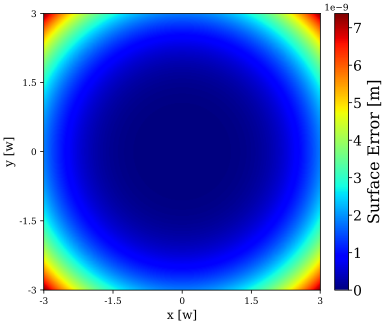

In [7]:
R = 36
def phaseMap(w):
    x = y = np.linspace(-1, 1, 800)*w*3 
    xx, yy = np.meshgrid(x, y)
    
    sphere = R - R*(1 - (xx**2+yy**2)/R**2)**0.5
    parabaloid = (xx**2+yy**2)/(2*R)
    
    deltaz_map = (sphere - parabaloid)

    return deltaz_map

deltaz_map = phaseMap(w_PR3)

fig, ax = plt.subplots(figsize=(7, 5,))

img = ax.imshow(deltaz_map, cmap="jet",)# norm=LogNorm(vmin=deltaz_map.max()*1e-6, vmax=deltaz_map.max()))

ax.set_xticks([0, 200, 400, 600, 799])
ax.set_xticklabels([-3, -1.5, 0, 1.5, 3])

ax.set_yticks([0, 200, 400, 600, 799])
ax.set_yticklabels([-3, -1.5, 0, 1.5, 3])

ax.set_xlabel("x [w]", fontsize=12)
ax.set_ylabel("y [w]", fontsize=12)

ax.grid()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img, cax=cax,)
cbar.set_label(label=r"Surface Error [m]", fontsize=16, rotation=90, labelpad=5)
# cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);

In [7]:
w = w_PR3
R = 36
factor = k*w**4/(32*R**3)
factor

3.363224043213929e-05

In [8]:
def HOMScattering(w):
    kat1 = kat.deepcopy()
    # kat1.L0.p1.o.q = BeamParam(w0=w, z=-1)
    kat1.PR3.p1.i.q = BeamParam(w=w, Rc=np.inf)

    deltaz_map = phaseMap(w)
    
    x = y = np.linspace(-1, 1, 800)*w*3
    kat1.PR3.surface_map = Map(x, y, opd=deltaz_map)

    out1 = kat1.run("noxaxis()")

    factor = k*w**4/(32*R**3)
    
    return factor, out1["HG00"], out1["HG20"], out1["HG02"], out1["HG40"], out1["HG04"], out1["HG22"]

factor, HG00, HG20, HG02, HG40, HG04, HG22 = HOMScattering(w_PR3)
np.abs(HG20)/factor, np.abs(HG02)/factor, np.abs(HG40)/factor, np.abs(HG04)/factor, np.abs(HG22)/factor

(5.656838894456306,
 5.656838894456307,
 2.4492002501634156,
 2.449200250163414,
 1.999993700384259)

In [9]:
factor20, factor40, factor22 = 4*2**(1/2), 6**(1/2), 2
factor20, factor40, factor22

(5.656854249492381, 2.449489742783178, 2)

In [10]:
ws = (1 + np.linspace(-0.2, 2, 100))*w_PR3

HG20s = []
HG02s = []
HG04s = []
HG40s = []
HG22s = []
HG00s = []
factors = []
for w in ws:
    factor, HG00, HG20, HG02, HG40, HG04, HG22 = HOMScattering(w)
    HG00s.append(HG00)
    HG20s.append(HG20)
    HG02s.append(HG02)
    HG04s.append(HG04)
    HG40s.append(HG40)
    HG22s.append(HG22)

    factors.append(factor)

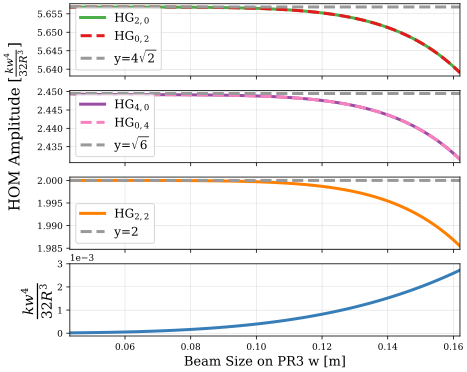

In [11]:
ws = (1 + np.linspace(-0.2, 2, 100))*w_PR3

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(7, 6,), sharex=True)

ax[0].plot(ws, np.abs(HG20s)/np.array(factors), lw=3, color=CB_color_cycle[2], label="$\mathrm{HG}_{2,0}$")
ax[0].plot(ws, np.abs(HG02s)/np.array(factors), lw=3, color=CB_color_cycle[7], ls="--", label="$\mathrm{HG}_{0,2}$")

plt.subplots_adjust(hspace=0.2) 

ax[1].plot(ws, np.abs(HG40s)/np.array(factors), lw=3, color=CB_color_cycle[5], label="$\mathrm{HG}_{4,0}$")
ax[1].plot(ws, np.abs(HG04s)/np.array(factors), lw=3, color=CB_color_cycle[3], ls="--", label="$\mathrm{HG}_{0,4}$")

ax[2].plot(ws, np.abs(HG22s)/np.array(factors), lw=3, color=CB_color_cycle[1], label="$\mathrm{HG}_{2,2}$")

ax[3].plot(ws, factors, lw=3, color=CB_color_cycle[0], label="$\mathrm{HG}_{2,2}$")

ax[0].axhline(y=factor20, ls="--", color=CB_color_cycle[6], lw=3, label="y=$4\sqrt{2}$")
ax[1].axhline(y=factor40, ls="--", color=CB_color_cycle[6], lw=3, label="y=$\sqrt{6}$")
ax[2].axhline(y=factor22, ls="--", color=CB_color_cycle[6], lw=3, label="y=$2$")

# ax[0].axvline(x=w_PR3, ls="--", color=CB_color_cycle[6], lw=3,)

ax[3].set_xlabel('Beam Size on PR3 w [m]', fontsize=13)
ax[1].set_ylabel(r'HOM Amplitude [$\frac{kw^4}{32R^3}$]', fontsize=15, labelpad=10)
ax[3].set_ylabel(r'$\frac{kw^4}{32R^3}$', fontsize=20, labelpad=5)

ax[3].set_yticks([0, 1e-3, 2e-3, 3e-3,])
# ax[3].minorticks_off()
# ax[3].grid(visible=False, which='minor', axis="y",)
ax[3].ticklabel_format(axis='y',style='sci',scilimits=(1,4))

legend = ax[0].legend(fontsize=12, ncols=1, loc="lower left")
legend = ax[1].legend(fontsize=12, ncols=1, loc="lower left")
legend = ax[2].legend(fontsize=12, ncols=1, loc="lower left");

# fig.savefig('./Figures/SphericalAberration_HOMs.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

#### HOM scattering into 4th order modes and 2nd order modes

$$
\mathrm{HG}_{0,0} \cdot e^{i\delta \phi} \Rightarrow \mathrm{HG}_{0,0} + i\frac{k w^4}{32 R^3} \left(\underbrace{\sqrt{6}\times \mathrm{HG}_{4,0} \cdot e^{-4i\Psi}+ \sqrt{6}\times \mathrm{HG}_{0,4}\cdot e^{-4i\Psi} + 2\times \mathrm{HG}_{2,2}\cdot e^{-4i\Psi}}_\text{4th-order modes} + \underbrace{4\sqrt{2}\times \mathrm{HG}_{2,0}\cdot e^{-2i\Psi} + 4\sqrt{2}\times \mathrm{HG}_{0,2}\cdot e^{-2i\Psi}}_\text{2nd-order modes} + 4\times \mathrm{HG}_{0,0} \right)
$$

In [89]:
def fieldsNewBasis(fields=[1, 0, 0, 0, 0, 0], q_old=(qx_out, qy_out)): # [HG00, HG20, HG02, HG40, HG04, HG22]
    qx, qy, field_content = optimise_HG00_q(e=fields, q=q_old, homs=[(0,0), (2,0), (0,2), (4,0), (0,4), (2,2)], 
                      return_field=True, accuracy=1e-9)

    return field_content

In [90]:
trace = kat.beam_trace()
qx_out, qy_out = trace[kat.Point.p2.o]

ws = (1 + np.linspace(-0.2, 2, 100))*w_PR3
HG20s_NB = []
HG02s_NB = []
HG04s_NB = []
HG40s_NB = []
HG22s_NB = []
HG00s_NB = []
factors_NB = []
for w in ws:
    factor, HG00, HG20, HG02, HG40, HG04, HG22 = HOMScattering(w)

    fields = [HG00, HG20, HG02, HG40, HG04, HG22]
    HG00_new, HG20_new, HG02_new, HG40_new, HG04_new, HG22_new = fieldsNewBasis(fields, q_old=(qx_out, qy_out))

    HG00s_NB.append(HG00_new)
    HG20s_NB.append(HG20_new)
    HG02s_NB.append(HG02_new)
    HG04s_NB.append(HG04_new)
    HG40s_NB.append(HG40_new)
    HG22s_NB.append(HG22_new)

    factors_NB.append(factor)

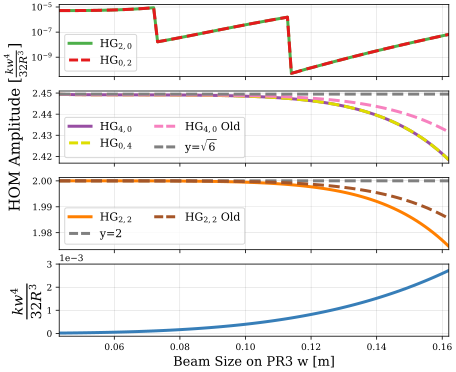

In [91]:
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(7, 6,), sharex=True)
plt.subplots_adjust(hspace=0.2) 

ax[0].semilogy(ws, np.abs(HG20s_NB)/np.array(factors_NB), lw=3, color=CB_color_cycle[2], label="$\mathrm{HG}_{2,0}$")
ax[0].semilogy(ws, np.abs(HG02s_NB)/np.array(factors_NB), lw=3, color=CB_color_cycle[7], ls="--", label="$\mathrm{HG}_{0,2}$")

ax[1].plot(ws, np.abs(HG40s_NB)/np.array(factors_NB), lw=3, color=CB_color_cycle[5], label="$\mathrm{HG}_{4,0}$")
ax[1].plot(ws, np.abs(HG04s_NB)/np.array(factors_NB), lw=3, color=CB_color_cycle[8], ls="--", label="$\mathrm{HG}_{0,4}$")
ax[1].plot(ws, np.abs(HG40s)/np.array(factors), lw=3, color=CB_color_cycle[3], ls="--", label="$\mathrm{HG}_{4,0}$ Old")

ax[2].plot(ws, np.abs(HG22s_NB)/np.array(factors_NB), lw=3, color=CB_color_cycle[1], ls="-", label="$\mathrm{HG}_{2,2}$")

ax[3].plot(ws, factors_NB, lw=3, color=CB_color_cycle[0], )

ax[1].axhline(y=factor40, ls="--", color='gray', lw=3, label="y=$\sqrt{6}$")
ax[2].axhline(y=factor22, ls="--", color='gray', lw=3, label="y=$2$")

ax[2].plot(ws, np.abs(HG22s)/np.array(factors), lw=3, color=CB_color_cycle[4], ls="--", label="$\mathrm{HG}_{2,2}$ Old")

ax[3].set_xlabel('Beam Size on PR3 w [m]', fontsize=13)
ax[1].set_ylabel(r'HOM Amplitude [$\frac{kw^4}{32R^3}$]', fontsize=15, labelpad=5)
ax[3].set_ylabel(r'$\frac{kw^4}{32R^3}$', fontsize=20, labelpad=5)

ax[3].set_yticks([0, 1e-3, 2e-3, 3e-3,])
ax[3].ticklabel_format(axis='y',style='sci',scilimits=(1,4))

legend0 = ax[0].legend(fontsize=11, ncols=1, loc="lower left")
legend1 = ax[1].legend(fontsize=11, ncols=2, loc="lower left")
legend2 = ax[2].legend(fontsize=11, ncols=2, loc="lower left")

legend_lines = legend0.get_lines()+legend1.get_lines()+legend2.get_lines()
for line in legend_lines:
    if not line.get_linestyle() == "-":
        line.set_linestyle((0, (3, 1)))

# fig.savefig('./Figures/SphericalAberration_4th.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

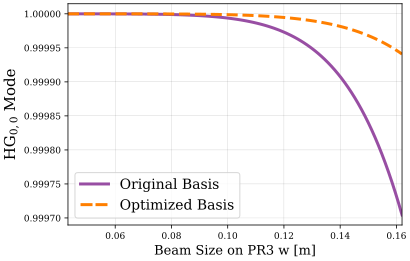

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4,))

ax.plot(ws, np.abs(HG00s), lw=3, color=CB_color_cycle[5], label="Original Basis")
ax.plot(ws, np.abs(HG00s_NB), lw=3, color=CB_color_cycle[1], ls="--", label="Optimized Basis")

legend0 = ax.legend(fontsize=14, ncols=1, loc="lower left")

legend_lines = legend0.get_lines()
for line in legend_lines:
    if not line.get_linestyle() == "-":
        line.set_linestyle((0, (4, 1)))

ax.set_xlabel('Beam Size on PR3 w [m]', fontsize=13)
ax.set_ylabel("$\mathrm{HG}_{0,0}$ Mode", fontsize=15, labelpad=5);

### Optimize the HG mode basis

In [16]:
index = np.abs(HG20s).argmax()
HG20 = HG20s[index]
HG00 = HG00s[index]
HG02 = HG02s[index]
HG22 = HG22s[index]
HG04 = HG04s[index]
HG40 = HG40s[index]

fields = [HG00, HG20, HG02, HG22, HG40, HG04]
np.abs(fields) # field contents

array([0.99970441, 0.01536197, 0.01536197, 0.00540887, 0.00662405,
       0.00662405])

In [20]:
qx, qy, field_content = optimise_HG00_q(e=fields, q=(qx_out, qy_out), homs=[(0,0), (2,0), (0,2), (2,2), (4,0), (0,4)], 
                      return_field=True, accuracy=1e-9)
# optical field described by a vector of HG modes in a different basis to minimize 2nd order mode
qx, qy

(❮BeamParam (w0=112.76 um, w=51.065 mm, z=-17.002 m, nr=1, λ=1.064 um) at 0x16e016010❯,
 ❮BeamParam (w0=112.76 um, w=51.065 mm, z=-17.002 m, nr=1, λ=1.064 um) at 0x16e0a9cd0❯)

In [26]:
w_new = qx.beamsize(z=1)
w_new*1e3

3.005678575802681

In [27]:
Sc_new = qx.curvature(z=1)
Sc_0 = qx_out.curvature(z=1)

Sc_new, Sc_0

(0.9985925757335241, 0.9985858999916624)

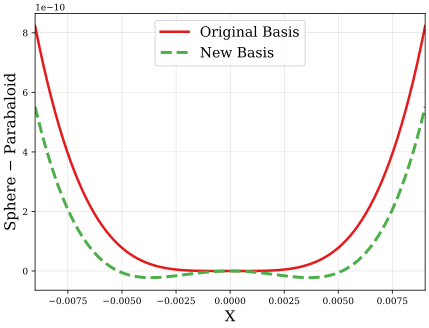

In [28]:
x = np.linspace(-1, 1, 100)*w_new*3
R = 1/Sc_0
R_new = 1/Sc_new

sphere = R - R*(1 - x**2/R**2)**0.5
parabaloid = x**2/(2*R)
parabaloid_new = x**2/(2*R_new)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))

ax.plot(x, sphere-parabaloid, lw=2.5, color=CB_color_cycle[7], label="Original Basis")
# ax.plot(x, parabaloid, lw=2.5, color=CB_color_cycle[2], ls="-.", label="Parabaloidial Mirror")
ax.plot(x, sphere-parabaloid_new, lw=3, color=CB_color_cycle[2], ls="--", label="New Basis")

ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Sphere $-$ Parabaloid', fontsize=15)
legend = ax.legend(fontsize=14, ncols=1, loc="best");

### Off-centered beam

In [12]:
kat = finesse.Model()
kat.modes(maxtem=6)

w = 5.4e-2
Rc = np.inf
kat.parse(
    f"""
    gauss input PR3.p1.i priority=1 w={w} Rc={Rc}

    l L0 P=1

    s s0 L0.p1 PR3.p1 L=1

    bs PR3 R=1 T=0 Rc=36 alpha=0

    s s1 PR3.p2 Point.p1 L=1
    
    nothing Point

    ad HG00 Point.p2.o f=0 n=0 m=0
    ad HG10 Point.p2.o f=0 n=1 m=0
#    ad HG30 Point.p2.o f=0 n=3 m=0
#    ad HG12 Point.p2.o f=0 n=1 m=2

    ad HG20 Point.p2.o f=0 n=2 m=0
    ad HG02 Point.p2.o f=0 n=0 m=2

    ad HG40 Point.p2.o f=0 n=4 m=0
    ad HG04 Point.p2.o f=0 n=0 m=4
    ad HG22 Point.p2.o f=0 n=2 m=2

    noxaxis()

    """
)

In [13]:
def phaseMap_off(w, a=0):
    x = y = np.linspace(-1, 1, 800)*w*3 
    xx, yy = np.meshgrid(x, y)

    # sphere = R - R*(1 - ((xx-a)**2+(yy-a)**2)/R**2)**0.5
    sphere = R - R*(1 - ((xx-a)**2+yy**2)/R**2)**0.5
    parabaloid = (xx**2+yy**2)/(2*R)
    
    deltaz_map = (sphere - parabaloid)

    return deltaz_map

def fieldsNewBasis_off(fields=[1, 0, 0, 0, 0, 0], q_old=(qx_out, qy_out)): # [HG00, HG10, HG20, HG02, HG40, HG04, HG22]
    qx, qy, field_content = optimise_HG00_q(e=fields, q=q_old, homs=[(0,0), (1,0), (2,0), (0,2), (4,0), (0,4), (2,2)], 
                      return_field=True, accuracy=1e-9)

    return field_content

def HOMScattering_off(w, a=0, tilt=False):
    kat1 = kat.deepcopy()
    kat1.PR3.p1.i.q = BeamParam(w=w, Rc=np.inf)
    
    if tilt:
        kat1.PR3.xbeta = -a/R
        # kat1.PR3.ybeta = a/R

    deltaz_map = phaseMap_off(w, a)
    
    x = y = np.linspace(-1, 1, 800)*w*3
    kat1.PR3.surface_map = Map(x, y, opd=deltaz_map)

    out1 = kat1.run("noxaxis()")

    factor_10 = k*a*w/R
    factor_4th = k*w**4/(32*R**3)

    # factor_30 = k*a*w**3/R**3

    return factor_10, factor_4th, out1["HG00"], out1["HG10"], out1["HG20"], out1["HG02"], out1["HG40"], out1["HG04"], out1["HG22"]

w0 = 5.4e-2
a = 1e-5*w0
R = 36
lambd = 1064e-9
k = 2*np.pi/lambd
factor_10, factor_4th, HG00, HG10, HG20, HG02, HG40, HG04, HG22 = HOMScattering_off(w0, a=a, tilt=False)
factor_10, factor_4th, np.abs(HG10)/factor_10, np.abs(HG40)/factor_4th, np.abs(HG22)/factor_4th

(0.004783251972570925,
 3.363224043213932e-05,
 0.9999893860285773,
 2.4487313485698357,
 1.9997962626734267)

In [14]:
factor_10, factor_4th, HG00, HG10, HG20, HG02, HG40, HG04, HG22 = HOMScattering_off(w0, a=a, tilt=True)
factor_10, factor_4th, np.abs(HG10)/factor_10, np.abs(HG40)/factor_4th, np.abs(HG22)/factor_4th

(0.004783251972570925,
 3.363224043213932e-05,
 1.0892886023183622e-06,
 2.449207605947769,
 2.000002174906303)

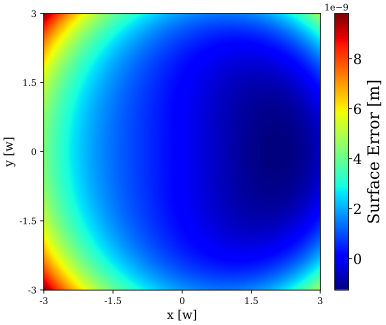

In [15]:
deltaz_map = phaseMap_off(w0, a=a)

fig, ax = plt.subplots(figsize=(7, 5,))

img = ax.imshow(deltaz_map, cmap="jet")

ax.set_xticks([0, 200, 400, 600, 799])
ax.set_xticklabels([-3, -1.5, 0, 1.5, 3])

ax.set_yticks([0, 200, 400, 600, 799])
ax.set_yticklabels([-3, -1.5, 0, 1.5, 3])

ax.set_xlabel("x [w]", fontsize=12)
ax.set_ylabel("y [w]", fontsize=12)

ax.grid()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img, cax=cax,)
cbar.set_label(label=r"Surface Error [m]", fontsize=16, rotation=90, labelpad=5)
# cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);

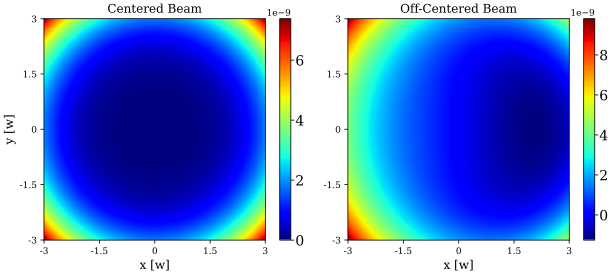

In [19]:
deltaz_map_off = phaseMap_off(w0, a=a)
deltaz_map = phaseMap(w_PR3)

fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4,))

img = ax.imshow(deltaz_map, cmap="jet")

ax.set_xlabel("x [w]", fontsize=12)
ax.set_ylabel("y [w]", fontsize=12)

ax.set_xticks([0, 200, 400, 600, 799])
ax.set_xticklabels([-3, -1.5, 0, 1.5, 3])

ax.set_yticks([0, 200, 400, 600, 799])
ax.set_yticklabels([-3, -1.5, 0, 1.5, 3])

ax.grid()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img, cax=cax,)
# cbar.set_label(label=r"$alpha$ [m]", fontsize=16, rotation=90, labelpad=5)
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);


img1 = ax1.imshow(deltaz_map_off, cmap="jet")

ax1.set_xticks([0, 200, 400, 600, 799])
ax1.set_xticklabels([-3, -1.5, 0, 1.5, 3])

ax1.set_yticks([0, 200, 400, 600, 799])
ax1.set_yticklabels([-3, -1.5, 0, 1.5, 3])

ax1.set_xlabel("x [w]", fontsize=12)
# ax.set_ylabel("y [w]", fontsize=12)

ax1.grid()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.2)
cbar1 = fig.colorbar(img1, cax=cax1,)
# cbar1.set_label(label=r"Surface Error [m]", fontsize=16, rotation=90, labelpad=5)
cbar1.ax.tick_params(labelsize=14, rotation=0, pad=1);

ax.set_title(r"Centered Beam", fontsize=12)
ax1.set_title(r"Off-Centered Beam", fontsize=12);

# fig.savefig('./Figures/Map_Centering.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [97]:
trace = kat.beam_trace()
qx_out, qy_out = trace[kat.Point.p2.o]
qx_out

❮BeamParam (w0=112.89 um, w=51 mm, z=-17 m, nr=1, λ=1.064 um) at 0x17413e050❯

In [98]:
offsets = np.linspace(1e-6, 5e-4, 10)*w0

HG00s_off = []
HG10s_off = []
HG40s_off = []
HG04s_off = []
HG22s_off = []

HG00s_off_tilt = []
HG10s_off_tilt = []
HG40s_off_tilt = []
HG04s_off_tilt = []
HG22s_off_tilt = []

factor_10s = []
factor_4ths = []
for a in offsets:
    factor_10, factor_4th, HG00, HG10, HG20, HG02, HG40, HG04, HG22 = HOMScattering_off(w0, a=a, tilt=False)

    fields_off = [HG00, HG10, HG20, HG02, HG40, HG04, HG22]
    HG00_new, HG10_new, HG20_new, HG02_new, HG40_new, HG04_new, HG22_new = fieldsNewBasis_off(fields_off, q_old=(qx_out, qy_out))
    
    HG00s_off.append(HG00_new)
    HG10s_off.append(HG10_new)
    HG40s_off.append(HG40_new)
    HG04s_off.append(HG04_new)
    HG22s_off.append(HG22_new)
    factor_10s.append(factor_10)
    factor_4ths.append(factor_4th)

    # apply mirror tilt to cancel the beam off-center effect
    factor_10, factor_4th, HG00, HG10, HG20, HG02, HG40, HG04, HG22 = HOMScattering_off(w0, a=a, tilt=True)

    fields_off = [HG00, HG10, HG20, HG02, HG40, HG04, HG22]
    HG00_new, HG10_new, HG20_new, HG02_new, HG40_new, HG04_new, HG22_new = fieldsNewBasis_off(fields_off, q_old=(qx_out, qy_out))
    
    HG00s_off_tilt.append(HG00_new)
    HG10s_off_tilt.append(HG10_new)
    HG40s_off_tilt.append(HG40_new)
    HG04s_off_tilt.append(HG04_new)
    HG22s_off_tilt.append(HG22_new)

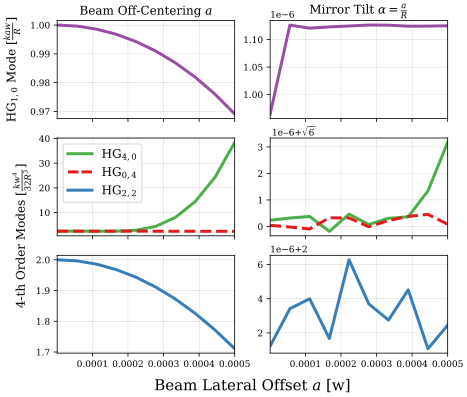

In [99]:
fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(7, 6,), sharex=True, )
plt.subplots_adjust(hspace=0.2, wspace=0.2)

ax1.plot(offsets/w0, np.abs(HG10s_off)/np.array(factor_10s), lw=3, ls="-", color=CB_color_cycle[5], label="$\mathrm{HG}_{1,0}$")

ax2.plot(offsets/w0, np.abs(HG40s_off)/np.array(factor_4ths), lw=3, ls="-", color=CB_color_cycle[2], label="$\mathrm{HG}_{4,0}$")
ax2.plot(offsets/w0, np.abs(HG04s_off)/np.array(factor_4ths), lw=3, ls="--", color=CB_color_cycle[7], label="$\mathrm{HG}_{0,4}$")
ax2.plot([], [], lw=3, ls="-", color=CB_color_cycle[0], label="$\mathrm{HG}_{2,2}$")

ax3.plot(offsets/w0, np.abs(HG22s_off)/np.array(factor_4ths), lw=3, ls="-", color=CB_color_cycle[0], label="$\mathrm{HG}_{2,2}$")


ax4.plot(offsets/w0, np.abs(HG10s_off_tilt)/np.array(factor_10s), lw=3, ls="-", color=CB_color_cycle[5], label="$\mathrm{HG}_{1,0}$")

ax5.plot(offsets/w0, np.abs(HG40s_off_tilt)/np.array(factor_4ths), lw=3, ls="-", color=CB_color_cycle[2], label="$\mathrm{HG}_{1,0}$")
ax5.plot(offsets/w0, np.abs(HG04s_off_tilt)/np.array(factor_4ths), lw=3, ls="--", color=CB_color_cycle[7], label="$\mathrm{HG}_{1,0}$")

ax6.plot(offsets/w0, np.abs(HG22s_off_tilt)/np.array(factor_4ths), lw=3, ls="-", color=CB_color_cycle[0], label="$\mathrm{HG}_{1,0}$")

# ax[2].plot(offsets/w0, factor_10s, lw=3, color=CB_color_cycle[0])

ax1.set_ylabel(r'$\mathrm{HG}_{1,0}$ Mode [$\frac{kaw}{R}$]', fontsize=12, labelpad=10)
ax3.set_ylabel(r'4-th Order Modes [$\frac{kw^4}{32R^3}$]', fontsize=12, labelpad=5, y=1.2)

ax3.set_xlabel(r"Beam Lateral Offset $a$ [w]", fontsize=15, labelpad=10, x=1.1)

ax1.set_title("Beam Off-Centering $a$", fontsize=12)
ax4.set_title(r"Mirror Tilt $\alpha=\frac{a}{R}$", fontsize=12, pad=7)

ax5.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax6.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

ax6.get_yaxis().get_major_formatter().set_useOffset(True)
offset = ax6.yaxis.get_offset_text()
font = offset.get_font()

ax5.get_yaxis().get_major_formatter().set_useOffset(True)
offset = ax5.yaxis.get_offset_text()
offset.set_visible(False)
text_to_display = "1e‒6+$\sqrt{6}$"
yoffset = ax5.text(0.01, 1.11, text_to_display, transform=ax5.transAxes, ha='left', va='top', color='k', font=font)

legend = ax2.legend(fontsize=12, ncols=1, loc="upper left");

legend_lines = legend.get_lines()
legend_lines[1].set_linestyle((0, (3.5, 1)))

# fig.savefig('./Figures/SphericalAberration_offcenter.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [37]:
x, y, a, R = sp.symbols('x y a R', real=True)
leading = (x**2+y**2)**2/(8*R**3)
paraboloid = (x**2+y**2)/(2*R)
diff_a = (paraboloid.subs(x, x-a) - paraboloid) + (leading.subs(x, x-a) - leading)

sp.expand(sp.series(diff_a, a, n=2).removeO())

-a*x/R - a*x**3/(2*R**3) - a*x*y**2/(2*R**3)

In [100]:
HG00s_off_tilt_w = []
HG10s_off_tilt_w = []
HG40s_off_tilt_w = []
HG04s_off_tilt_w = []
HG22s_off_tilt_w = []

factor_10s_w = []
factor_4ths_w = []
a = 5e-4*w0
R = 36
ws = (1 + np.linspace(-0.2, 2, 100))*w0
for w in ws:
    factor_10, factor_4th, HG00, HG10, HG20, HG02, HG40, HG04, HG22 = HOMScattering_off(w, a=a, tilt=True)

    fields_off = [HG00, HG10, HG20, HG02, HG40, HG04, HG22]
    HG00_new, HG10_new, HG20_new, HG02_new, HG40_new, HG04_new, HG22_new = fieldsNewBasis_off(fields_off, q_old=(qx_out, qy_out))
    
    HG00s_off_tilt_w.append(HG00_new)
    HG10s_off_tilt_w.append(HG10_new)
    HG40s_off_tilt_w.append(HG40_new)
    HG04s_off_tilt_w.append(HG04_new)
    HG22s_off_tilt_w.append(HG22_new)
    factor_10s_w.append(factor_10)
    factor_4ths_w.append(factor_4th)

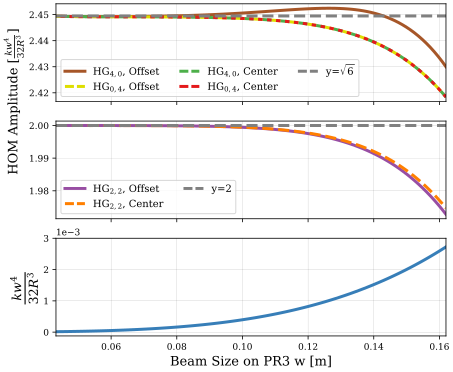

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(7, 6,), sharex=True)
plt.subplots_adjust(hspace=0.2) 

ax1.plot(ws, np.abs(HG40s_off_tilt_w)/np.array(factor_4ths_w), lw=3, color=CB_color_cycle[4], label="$\mathrm{HG}_{4,0}$, Offset")
ax1.plot(ws, np.abs(HG04s_off_tilt_w)/np.array(factor_4ths_w), lw=3, color=CB_color_cycle[8], ls=(0, (3, 3)), label="$\mathrm{HG}_{0,4}$, Offset")

ax1.plot(ws, np.abs(HG40s_NB)/np.array(factors_NB), lw=3, color=CB_color_cycle[2], ls=(3, (3, 3)), label="$\mathrm{HG}_{4,0}$, Center")
ax1.plot(ws, np.abs(HG04s_NB)/np.array(factors_NB), lw=3, color=CB_color_cycle[7], ls=(1.5, (1.5, 1.5)), label="$\mathrm{HG}_{0,4}$, Center")

ax2.plot(ws, np.abs(HG22s_off_tilt_w)/np.array(factor_4ths_w), lw=3, color=CB_color_cycle[5], ls="-", label="$\mathrm{HG}_{2,2}$, Offset")
ax2.plot(ws, np.abs(HG22s_NB)/np.array(factors_NB), lw=3, color=CB_color_cycle[1], ls="--", label="$\mathrm{HG}_{2,2}$, Center")

ax3.plot(ws, factor_4ths_w, lw=3, color=CB_color_cycle[0],)

ax1.axhline(y=factor40, ls="--", color='gray', lw=3, label="y=$\sqrt{6}$")
ax2.axhline(y=factor22, ls="--", color='gray', lw=3, label="y=$2$")

# ax1.plot(ws, np.abs(HG22s)/np.array(factors), lw=3, color=CB_color_cycle[4], ls="--", label="$\mathrm{HG}_{2,2}$ Old")

ax3.set_xlabel('Beam Size on PR3 w [m]', fontsize=13)
ax1.set_ylabel(r'HOM Amplitude [$\frac{kw^4}{32R^3}$]', fontsize=13, labelpad=5, y=0)
ax3.set_ylabel(r'$\frac{kw^4}{32R^3}$', fontsize=18, labelpad=5)

ax3.set_yticks([0, 1e-3, 2e-3, 3e-3,])
ax3.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

legend0 = ax1.legend(fontsize=10, ncols=3, loc="lower left")
legend1 = ax2.legend(fontsize=10, ncols=2, loc="lower left")
# legend2 = ax3.legend(fontsize=11, ncols=2, loc="lower left")

legend_lines = legend0.get_lines()+legend1.get_lines()
for line in legend_lines:
    if not line.get_linestyle() == "-":
        line.set_linestyle((0, (3, 1)))

# fig.savefig('./Figures/SphericalAberration_offcenter_w.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);